In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import jax.numpy as jnp
from tqdm.notebook import tqdm

import imageio
import cv2

import jax
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS

from pmwd import (
    Configuration,
    Cosmology, SimpleLCDM,
    boltzmann,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.particles import ptcl_pos
from pmwd.vis_util import plt_2d, CosmicWebNorm

import nvix.camera as nvixc
import nvix.utils as nvixu

from gaepsi2.painter import paint

In [5]:
ptcl_spacing = 4.
ptcl_grid_shape = (128,) * 3

conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=2)  # 2x mesh shape

In [6]:
cosmo = SimpleLCDM(conf)
seed = 0
modes = white_noise(seed, conf)

def model(modes, cosmo, conf):
    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    return ptcl, obsvbl

print(f'Simulating {conf.ptcl_num} particles with a {conf.mesh_shape} mesh for {conf.a_nbody_num} time steps.')
ptcl = model(modes, cosmo, conf)[0]

Simulating 2097152 particles with a (256, 256, 256) mesh for 63 time steps.


In [5]:
# dens = scatter(ptcl, conf)
# fig, _ = plt_2d(dens[:16].mean(axis=0), norm='CosmicWebNorm')
# plt.close(fig)

In [7]:
points = ptcl_pos(ptcl, conf).T
print(points.shape)

for i in range(3):
    print(f'{points[i, :].min():.2f}  -  {points[i, :].max():.2f}')

(3, 2097152)
0.00  -  512.00
0.00  -  512.00
0.00  -  512.00


In [8]:
# range of the cubic box, assumed to be the same for x, y, z
lim = np.array([0, 512])
box_size = lim[1] - lim[0]

# the model matrix to shift the box to the origin of the world space
M_model = np.eye(4)
M_model[:3, 3] = np.full(3, -lim.mean())

# the camera is at postive z and facing the origin of the world space
eye = np.array([0, 0, box_size*5])
target = np.array([0, 0, 0])

# field of view angle
fovy = np.arctan2(box_size/2, eye[-1]) * 1.8 * 2

# distance of camera to near and far planes in world space
# set as the closer and further z planes of the cube
near = eye[-1] - box_size
far = eye[-1] + box_size * 2

# window size
window = (128, 128)

In [9]:
X = nvixc.shutter(points, eye, target, fovy, near, far, M_model=M_model, window=window)

In [10]:
X.shape

(3, 2097152)

In [11]:
for i in range(3):
    print(f'{X[i, :].min():.2f}  -  {X[i, :].max():.2f}')

24.82  -  103.19
24.81  -  103.20
-0.48  -  0.27


In [12]:
X_p = paint(np.array(X.T), np.full(X.shape[1], 1.), np.ones(X.shape[1]), window)[0].T
X_p.shape

(128, 128)

In [13]:
# X_p = nvixc.paint(X, [[-1, 1], [-1, 1]], pixels=(256, 256))

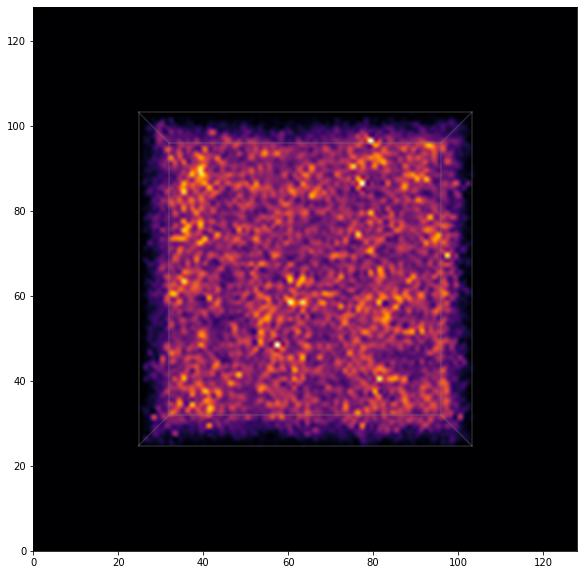

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim(0, window[0]); ax.set_ylim(0, window[1])

# draw the box
xs, ys, zs = np.meshgrid(lim, lim, lim)
vs = np.vstack([_.ravel() for _ in (xs, ys, zs)])
vs = nvixc.shutter(vs, eye, target, fovy, near, far, M_model=M_model, window=window)
nvixu.draw_box(vs, ax)
# ax.scatter(vs[0], vs[1], color=list(TABLEAU_COLORS.keys())[:8])

# show particles
ax.imshow(X_p, extent=(0, 128, 0, 128), cmap='inferno', vmin=0, vmax=1000,
          interpolation='lanczos', interpolation_stage='rgba')
# ax.imshow(X_p, extent=(0, 128, 0, 128), cmap='inferno', norm=CosmicWebNorm(X_p),
#           interpolation='lanczos', interpolation_stage='rgba')

In [26]:
# rotate the camera around y axis in world space
for i, step in enumerate(tqdm(np.linspace(0, 1, 200))):
    rot = nvixu.rotation('y', step * 2 * np.pi)
    eye_n = rot @ eye

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_xlim(0, window[0]); ax.set_ylim(0, window[1])

    # draw the box
    xs, ys, zs = np.meshgrid(lim, lim, lim)
    vs = np.vstack([_.ravel() for _ in (xs, ys, zs)])
    vs = nvixc.shutter(vs, eye_n, target, fovy, near, far, M_model=M_model, window=window)
    nvixu.draw_box(vs, ax)

    # show particles
    X = nvixc.shutter(points, eye_n, target, fovy, near, far, M_model=M_model, window=window)
    X_p = paint(np.array(X.T), np.full(X.shape[1], 3.), np.ones(X.shape[1]), window)[0].T
    ax.imshow(X_p, extent=(0, 128, 0, 128), cmap='inferno', vmin=0, vmax=1000,
              interpolation='lanczos', interpolation_stage='rgba')
    # ax.imshow(X_p, extent=(0, window[0], 0, window[1]), cmap='inferno', norm=CosmicWebNorm(X_p),
    #           interpolation='lanczos', interpolation_stage='rgba')
    fig.savefig(f'tmp/{i}.png', dpi=100, bbox_inches='tight')
    plt.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [21]:
writer = imageio.get_writer('test_nbody.mp4', fps=30)
for i in tqdm(range(200)):
    writer.append_data(imageio.imread(f'tmp/{i}.png'))
writer.close()

  0%|          | 0/200 [00:00<?, ?it/s]

[swscaler @ 0x7fdfe8048000] Warning: data is not aligned! This can lead to a speed loss


In [25]:
imageio.imread(f'tmp/1.png')

Array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0]]], dtype=uint8)

In [ ]:
images = []
for i in tqdm(range(200)):
    image = cv2.imread(f'tmp/{i}.png')
    images.append(image)

fps = 30
video = cv2.VideoWriter('test_rotate.mp4', cv2.VideoWriter_fourcc('M', '2', '6', '4'), fps, images[0].shape[:2])
for image in images:
    video.write(image)

cv2.destroyAllWindows()
video.release()

  0%|          | 0/200 [00:00<?, ?it/s]

OpenCV: FFMPEG: tag 0x3436324d/'M264' is not found (format 'mp4 / MP4 (MPEG-4 Part 14)')'


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/yucheng/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s


ValueError: array must not contain infs or NaNs

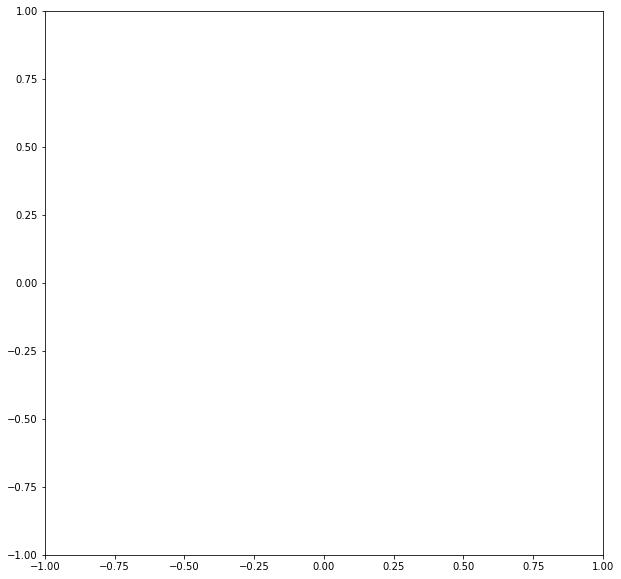

In [96]:
# move the camera forward
for i, step in enumerate(tqdm(np.linspace(0, 5, 100))):
    eye_n = np.array([0, 0, eye[-1] - step * box_size])
    target_n = np.array([0, 0, target[-1] - step * box_size])

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_xlim(-1, 1); ax.set_ylim(-1, 1)

    # draw the box
    xs, ys, zs = np.meshgrid(lim, lim, lim)
    vs = np.vstack([_.ravel() for _ in (xs, ys, zs)])
    vs = nvixc.shutter(vs, eye_n, target_n, fovy, near, far, M_model=M_model)
    # nvixu.draw_box(vs, ax)
    ax.scatter(vs[0], vs[1])

    X = nvixc.shutter(points, eye_n, target_n, fovy, near, far, M_model=M_model)
    X_p = nvixc.paint(X, [[-1, 1], [-1, 1]], pixels=(256, 256))
    ax.imshow(X_p, extent=(-1, 1, -1, 1), cmap='inferno', norm=CosmicWebNorm(X_p),
              interpolation='lanczos', interpolation_stage='rgba')
    fig.savefig(f'tmp/{i}.png')
    plt.close()

In [ ]:
with imageio.get_writer('test_zoomin.gif', mode='I') as writer:
    for i in range(30):
        image = imageio.imread(f'tmp/{i}.png')
        writer.append_data(image)